In [1]:
import csv
import random
from typing import List, Optional

In [2]:

def backtracking_exact(adj_matrix: List[List[int]]) -> List[int]:
    """
    Find the maximum clique using exhaustive backtracking search.

    Args:
        adj_matrix: Adjacency matrix (2D list where adj_matrix[i][j] = 1 if edge exists)

    Returns:
        List of node indices forming the maximum clique
    """
    n = len(adj_matrix)
    best_clique = []
    current_clique = []

    def is_adjacent(u: int, v: int) -> bool:
        return adj_matrix[u][v] == 1

    def is_clique_candidate(u: int) -> bool:
        for v in current_clique:
            if not is_adjacent(u, v):
                return False
        return True

    def backtrack(start: int) -> None:
        nonlocal best_clique

        if len(current_clique) > len(best_clique):
            best_clique = current_clique.copy()

        if len(current_clique) + (n - start) <= len(best_clique):
            return

        for u in range(start, n):
            if is_clique_candidate(u):
                current_clique.append(u)
                backtrack(u + 1)
                current_clique.pop()

    backtrack(0)
    return sorted(best_clique)


# =============================================================================
# ALGORITHM 2: GREEDY MAX DEGREE
# =============================================================================

def greedy_max_degree(adj_matrix: List[List[int]]) -> List[int]:
    """
    Find a clique using a greedy heuristic based on maximum degree.

    Args:
        adj_matrix: Adjacency matrix (2D list where adj_matrix[i][j] = 1 if edge exists)

    Returns:
        List of node indices forming the found clique (may not be maximum)
    """
    n = len(adj_matrix)
    if n == 0:
        return []

    def get_degree(u: int) -> int:
        return sum(adj_matrix[u])

    def is_adjacent(u: int, v: int) -> bool:
        return adj_matrix[u][v] == 1

    clique = []
    used = [False] * n

    # Start with highest degree node
    start_node = max(range(n), key=get_degree)
    clique.append(start_node)
    used[start_node] = True

    changed = True
    while changed:
        changed = False
        best_node = -1
        best_degree = -1

        for u in range(n):
            if used[u]:
                continue

            # Check if u connects to all clique members
            connects_to_all = all(is_adjacent(u, v) for v in clique)

            if connects_to_all:
                deg = get_degree(u)
                if deg > best_degree:
                    best_degree = deg
                    best_node = u

        if best_node != -1:
            clique.append(best_node)
            used[best_node] = True
            changed = True

    return sorted(clique)


# =============================================================================
# ALGORITHM 3: BRANCH AND BOUND
# =============================================================================
def hill_climbing(adj_matrix: List[List[int]]) -> List[int]:
    """
    Find a clique using local search heuristic.
    Starts with greedy solution, then tries to improve by swapping nodes.
    """
    n = len(adj_matrix)
    if n == 0:
        return []

    def is_adjacent(u: int, v: int) -> bool:
        return adj_matrix[u][v] == 1

    def get_degree(u: int) -> int:
        return sum(adj_matrix[u])

    # Start with greedy solution
    nodes = sorted(range(n), key=get_degree, reverse=True)
    clique = []
    for u in nodes:
        if all(is_adjacent(u, v) for v in clique):
            clique.append(u)

    # Local search: try removing one node and adding two
    improved = True
    while improved:
        improved = False
        clique_set = set(clique)
        
        for remove in clique:
            # Nodes not in clique that connect to all except 'remove'
            candidates = []
            for u in range(n):
                if u in clique_set:
                    continue
                others = [v for v in clique if v != remove]
                if all(is_adjacent(u, v) for v in others):
                    candidates.append(u)
            
            # Try adding two candidates that connect to each other
            for i in range(len(candidates)):
                for j in range(i + 1, len(candidates)):
                    if is_adjacent(candidates[i], candidates[j]):
                        # Found improvement: remove 1, add 2
                        clique = [v for v in clique if v != remove]
                        clique.extend([candidates[i], candidates[j]])
                        improved = True
                        break
                if improved:
                    break
            if improved:
                break

    return sorted(clique)


In [3]:
# def greedy_max_degree(adj_matrix: List[List[int]]) -> List[int]:
# def hill_climbing(adj_matrix: List[List[int]]) -> List[int]:
# def backtracking_exact(adj_matrix: List[List[int]]) -> List[int]:

In [4]:

def generate_adjacency_matrix(num_nodes: int, density: float, seed: Optional[int] = None) -> List[List[int]]:
    """
    Generate a random adjacency matrix with specified nodes and edge density.

    Args:
        num_nodes: Number of nodes in the graph
        density: Edge density (0.0 to 1.0)
        seed: Optional random seed for reproducibility

    Returns:
        Adjacency matrix as 2D list
    """
    if seed is not None:
        random.seed(seed)

    matrix = [[0] * num_nodes for _ in range(num_nodes)]

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < density:
                matrix[i][j] = 1
                matrix[j][i] = 1

    return matrix


In [5]:
def read_matrix_from_csv(filepath: str) -> List[List[int]]:
    """
    Read adjacency matrix from CSV file.

    Args:
        filepath: Path to CSV file containing the adjacency matrix

    Returns:
        Adjacency matrix as 2D list
    """
    with open(filepath, 'r', newline='') as f:
        reader = csv.reader(f)
        matrix = [[int(val) for val in row] for row in reader]
    return matrix


def write_results_to_csv(filepath: str, results: dict) -> None:
    """
    Write algorithm results to CSV file.

    Args:
        filepath: Path to output CSV file
        results: Dictionary containing results from each algorithm
    """
    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['algorithm', 'clique_size', 'clique_nodes'])
        for alg_name, clique in results.items():
            writer.writerow([alg_name, len(clique), ' '.join(map(str, clique))])


def run_all_algorithms(adj_matrix: List[List[int]], output_csv: str) -> dict:
    """
    Run all three algorithms on the given adjacency matrix and write results to CSV.

    Args:
        adj_matrix: Adjacency matrix (2D list)
        output_csv: Path to output CSV file

    Returns:
        Dictionary with results from each algorithm
    """
    results = {
        'backtracking_exact': backtracking_exact(adj_matrix),
        'greedy_max_degree': greedy_max_degree(adj_matrix),
        'hill_climbing': hill_climbing(adj_matrix)
    }

    write_results_to_csv(output_csv, results)
    return results


In [6]:
matrix = generate_adjacency_matrix(num_nodes=20, density=0.4, seed=42)

In [7]:
results = run_all_algorithms(matrix, 'clique_results.csv')

In [8]:
for alg, clique in results.items():
        print(f"  {alg}: size={len(clique)}, nodes={clique}")


  backtracking_exact: size=5, nodes=[0, 2, 8, 10, 11]
  greedy_max_degree: size=5, nodes=[0, 2, 8, 10, 11]
  hill_climbing: size=5, nodes=[0, 2, 8, 10, 11]


In [9]:
import time
import matplotlib.pyplot as plt

In [10]:
results = {
    'nodes': [],
    'backtracking_exact': [],
    'greedy_max_degree': [],
    'hill_climbing': []
}

In [11]:
import numpy as np


Test 1: 10 nodes, 0.1 density
  Clique sizes: Exact=2, Greedy=2, Hill=2
  Correct: Exact=1, Greedy=1, Hill=1
Test 2: 12 nodes, 0.1 density
  Clique sizes: Exact=2, Greedy=2, Hill=2
  Correct: Exact=1, Greedy=1, Hill=1
Test 3: 15 nodes, 0.1 density
  Clique sizes: Exact=2, Greedy=2, Hill=2
  Correct: Exact=1, Greedy=1, Hill=1
Test 4: 20 nodes, 0.1 density
  Clique sizes: Exact=2, Greedy=2, Hill=2
  Correct: Exact=1, Greedy=1, Hill=1
Test 5: 25 nodes, 0.1 density
  Clique sizes: Exact=3, Greedy=3, Hill=3
  Correct: Exact=1, Greedy=1, Hill=1
Test 6: 30 nodes, 0.1 density
  Clique sizes: Exact=3, Greedy=3, Hill=3
  Correct: Exact=1, Greedy=1, Hill=1
Test 7: 35 nodes, 0.1 density
  Clique sizes: Exact=3, Greedy=3, Hill=3
  Correct: Exact=1, Greedy=1, Hill=1
Test 8: 40 nodes, 0.1 density
  Clique sizes: Exact=4, Greedy=3, Hill=3
  Correct: Exact=1, Greedy=0, Hill=0
Test 9: 45 nodes, 0.1 density
  Clique sizes: Exact=3, Greedy=2, Hill=3
  Correct: Exact=1, Greedy=0, Hill=1
Test 10: 50 nodes, 

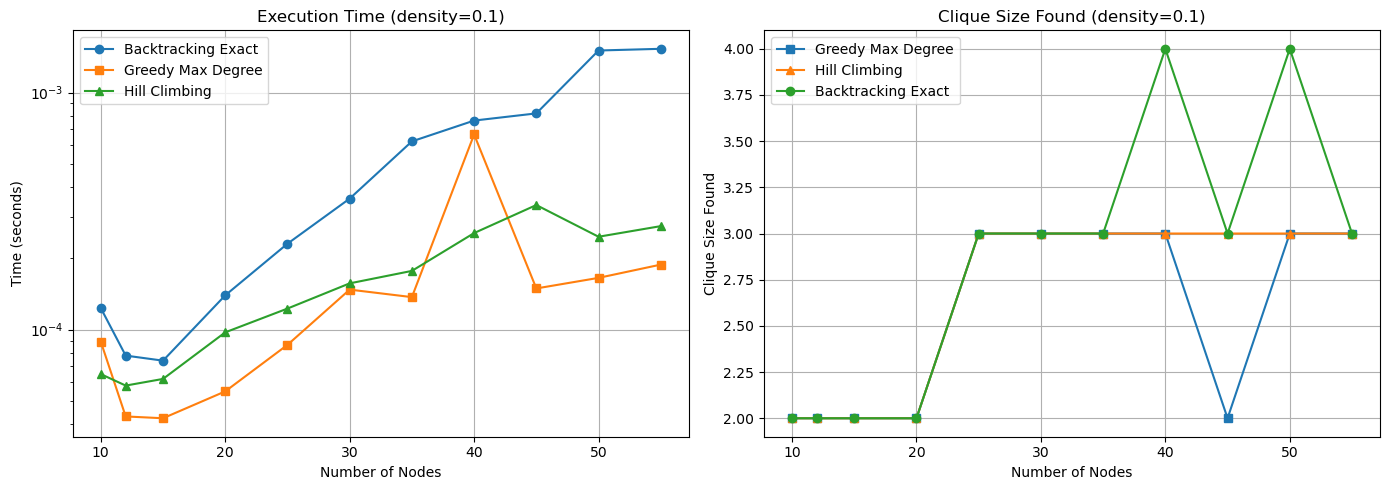

Test 1: 10 nodes, 0.3 density
  Clique sizes: Exact=2, Greedy=2, Hill=2
  Correct: Exact=1, Greedy=1, Hill=1
Test 2: 12 nodes, 0.3 density
  Clique sizes: Exact=3, Greedy=3, Hill=3
  Correct: Exact=1, Greedy=1, Hill=1
Test 3: 15 nodes, 0.3 density
  Clique sizes: Exact=3, Greedy=3, Hill=3
  Correct: Exact=1, Greedy=1, Hill=1
Test 4: 20 nodes, 0.3 density
  Clique sizes: Exact=3, Greedy=3, Hill=3
  Correct: Exact=1, Greedy=1, Hill=1
Test 5: 25 nodes, 0.3 density
  Clique sizes: Exact=4, Greedy=4, Hill=4
  Correct: Exact=1, Greedy=1, Hill=1
Test 6: 30 nodes, 0.3 density
  Clique sizes: Exact=4, Greedy=4, Hill=4
  Correct: Exact=1, Greedy=1, Hill=1
Test 7: 35 nodes, 0.3 density
  Clique sizes: Exact=5, Greedy=5, Hill=5
  Correct: Exact=1, Greedy=1, Hill=1
Test 8: 40 nodes, 0.3 density
  Clique sizes: Exact=5, Greedy=5, Hill=5
  Correct: Exact=1, Greedy=1, Hill=1
Test 9: 45 nodes, 0.3 density
  Clique sizes: Exact=5, Greedy=4, Hill=4
  Correct: Exact=1, Greedy=0, Hill=0
Test 10: 50 nodes, 

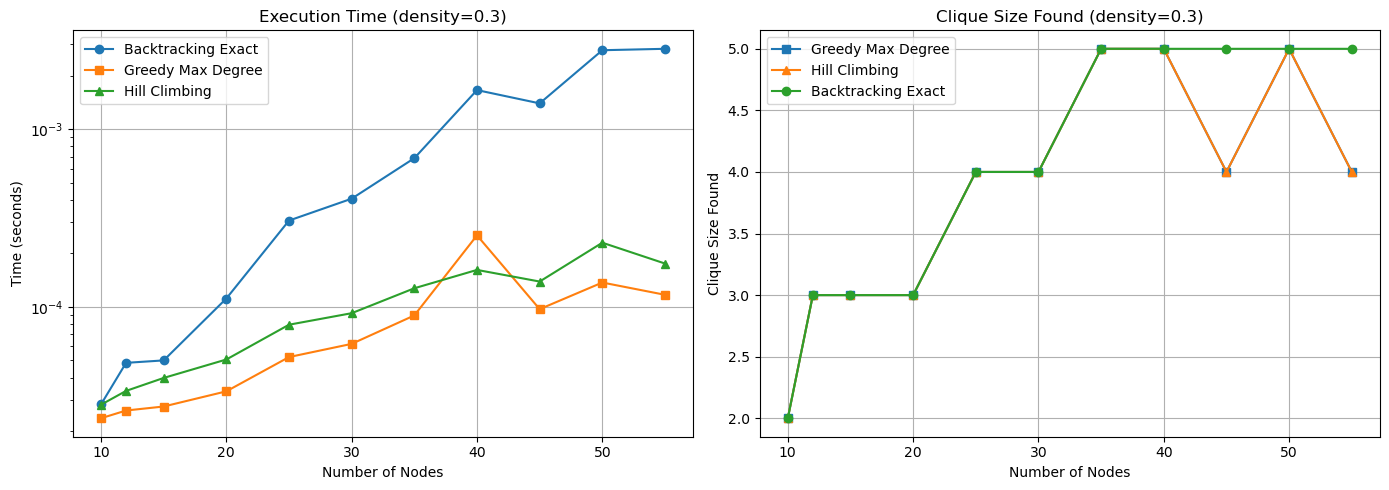

Test 1: 10 nodes, 0.5 density
  Clique sizes: Exact=4, Greedy=4, Hill=4
  Correct: Exact=1, Greedy=1, Hill=1
Test 2: 12 nodes, 0.5 density
  Clique sizes: Exact=4, Greedy=4, Hill=4
  Correct: Exact=1, Greedy=1, Hill=1
Test 3: 15 nodes, 0.5 density
  Clique sizes: Exact=4, Greedy=4, Hill=4
  Correct: Exact=1, Greedy=1, Hill=1
Test 4: 20 nodes, 0.5 density
  Clique sizes: Exact=5, Greedy=4, Hill=5
  Correct: Exact=1, Greedy=0, Hill=1
Test 5: 25 nodes, 0.5 density
  Clique sizes: Exact=6, Greedy=4, Hill=5
  Correct: Exact=1, Greedy=0, Hill=0
Test 6: 30 nodes, 0.5 density
  Clique sizes: Exact=6, Greedy=6, Hill=6
  Correct: Exact=1, Greedy=1, Hill=1
Test 7: 35 nodes, 0.5 density
  Clique sizes: Exact=6, Greedy=5, Hill=6
  Correct: Exact=1, Greedy=0, Hill=1
Test 8: 40 nodes, 0.5 density
  Clique sizes: Exact=8, Greedy=6, Hill=6
  Correct: Exact=1, Greedy=0, Hill=0
Test 9: 45 nodes, 0.5 density
  Clique sizes: Exact=8, Greedy=7, Hill=8
  Correct: Exact=1, Greedy=0, Hill=1
Test 10: 50 nodes, 

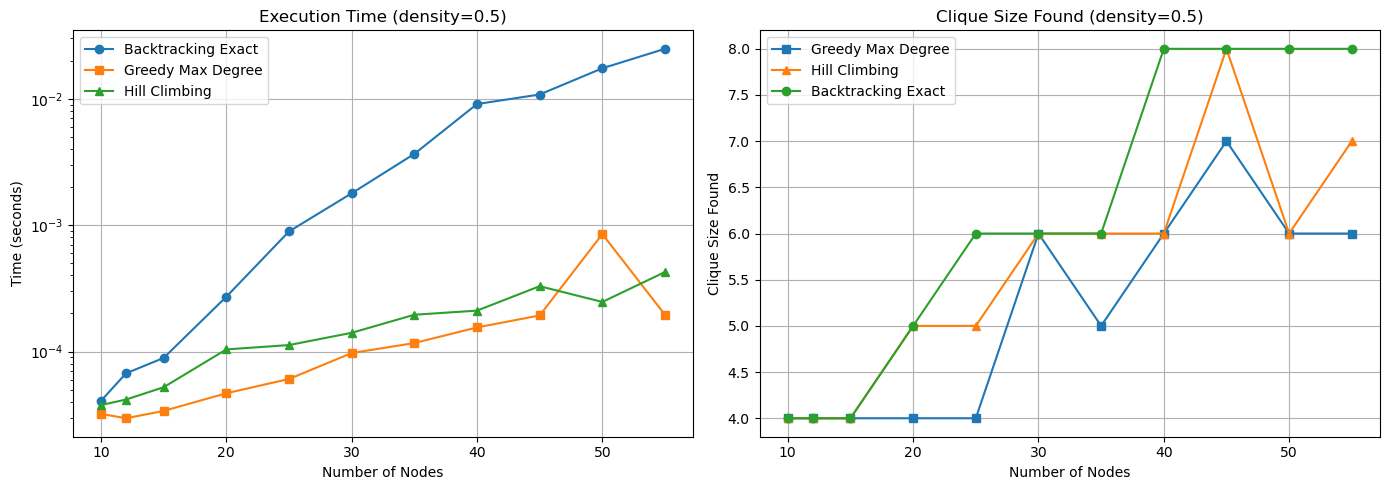

Test 1: 10 nodes, 0.7 density
  Clique sizes: Exact=4, Greedy=4, Hill=4
  Correct: Exact=1, Greedy=1, Hill=1
Test 2: 12 nodes, 0.7 density
  Clique sizes: Exact=5, Greedy=5, Hill=5
  Correct: Exact=1, Greedy=1, Hill=1
Test 3: 15 nodes, 0.7 density
  Clique sizes: Exact=5, Greedy=4, Hill=5
  Correct: Exact=1, Greedy=0, Hill=1
Test 4: 20 nodes, 0.7 density
  Clique sizes: Exact=8, Greedy=7, Hill=8
  Correct: Exact=1, Greedy=0, Hill=1
Test 5: 25 nodes, 0.7 density
  Clique sizes: Exact=8, Greedy=7, Hill=7
  Correct: Exact=1, Greedy=0, Hill=0
Test 6: 30 nodes, 0.7 density
  Clique sizes: Exact=9, Greedy=8, Hill=9
  Correct: Exact=1, Greedy=0, Hill=1
Test 7: 35 nodes, 0.7 density
  Clique sizes: Exact=11, Greedy=9, Hill=9
  Correct: Exact=1, Greedy=0, Hill=0
Test 8: 40 nodes, 0.7 density
  Clique sizes: Exact=11, Greedy=9, Hill=10
  Correct: Exact=1, Greedy=0, Hill=0
Test 9: 45 nodes, 0.7 density
  Clique sizes: Exact=10, Greedy=9, Hill=9
  Correct: Exact=1, Greedy=0, Hill=0
Test 10: 50 nod

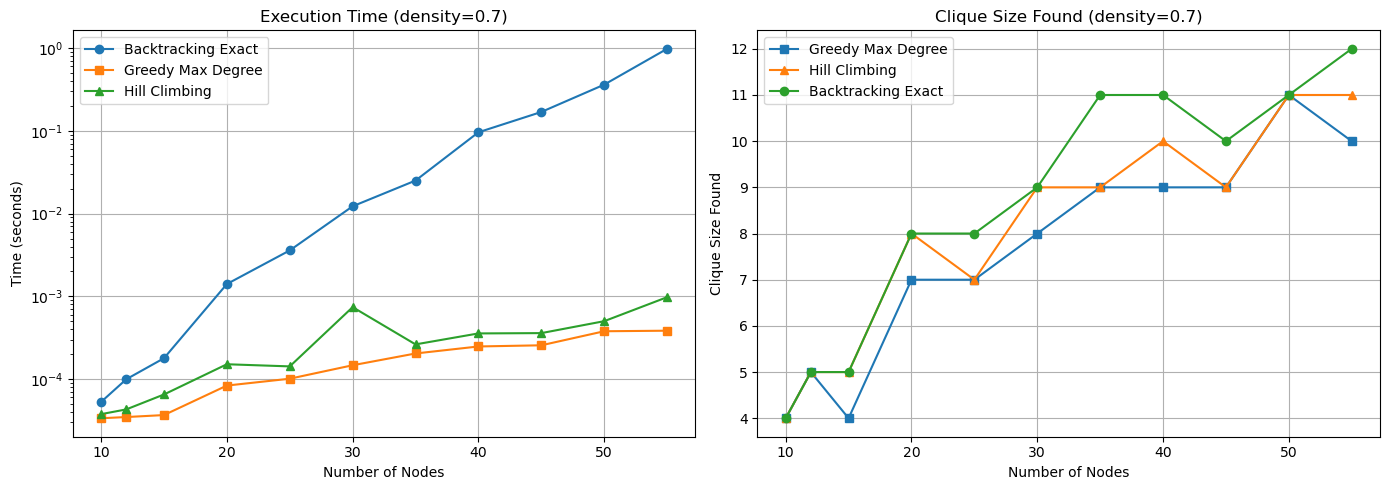


All plots saved!
Correctness results saved to correctness_results.csv


In [12]:
with open('correctness_results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['density', 'nodes', 'exact', 'greedy', 'hill_climbing'])
    
    for j in [0.1, 0.3, 0.5, 0.7]:
        test_configs = [
            {'nodes': 10, 'density': j},
            {'nodes': 12, 'density': j},
            {'nodes': 15, 'density': j},
            {'nodes': 20, 'density': j},
            {'nodes': 25, 'density': j},
            {'nodes': 30, 'density': j},
            {'nodes': 35, 'density': j},
            {'nodes': 40, 'density': j},
            {'nodes': 45, 'density': j},
            {'nodes': 50, 'density': j},
            {'nodes': 55, 'density': j},
        ]
        
        results = {
            'nodes': [],
            'backtracking_exact': [],
            'greedy_max_degree': [],
            'hill_climbing': [],
            'backtracking_exact_size': [],
            'greedy_max_degree_size': [],
            'hill_climbing_size': []
        }
        
        for i, config in enumerate(test_configs):
            print(f"Test {i+1}: {config['nodes']} nodes, {config['density']:.1f} density")
            
            matrix = generate_adjacency_matrix(config['nodes'], config['density'], seed=i)
            results['nodes'].append(config['nodes'])
            
            # Time backtracking_exact and store clique size
            start = time.perf_counter()
            clique = backtracking_exact(matrix)
            results['backtracking_exact'].append(time.perf_counter() - start)
            results['backtracking_exact_size'].append(len(clique))
            exact_size = len(clique)
            
            # Time greedy_max_degree and store clique size
            start = time.perf_counter()
            clique = greedy_max_degree(matrix)
            results['greedy_max_degree'].append(time.perf_counter() - start)
            results['greedy_max_degree_size'].append(len(clique))
            greedy_size = len(clique)
            
            # Time hill_climbing and store clique size
            start = time.perf_counter()
            clique = hill_climbing(matrix)
            results['hill_climbing'].append(time.perf_counter() - start)
            results['hill_climbing_size'].append(len(clique))
            hill_size = len(clique)
            
            # Check correctness (1 = correct/optimal, 0 = not optimal)
            exact_correct = 1
            greedy_correct = 1 if greedy_size == exact_size else 0
            hill_correct = 1 if hill_size == exact_size else 0
            
            # Write row to CSV
            writer.writerow([j, config['nodes'], exact_correct, greedy_correct, hill_correct])
            
            print(f"  Clique sizes: Exact={exact_size}, Greedy={greedy_size}, Hill={hill_size}")
            print(f"  Correct: Exact=1, Greedy={greedy_correct}, Hill={hill_correct}")
        
        # Create two subplots: one for time, one for clique size
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Execution time
        ax1.plot(results['nodes'], results['backtracking_exact'], 'o-', label='Backtracking Exact')
        ax1.plot(results['nodes'], results['greedy_max_degree'], 's-', label='Greedy Max Degree')
        ax1.plot(results['nodes'], results['hill_climbing'], '^-', label='Hill Climbing')
        ax1.set_xlabel('Number of Nodes')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_title(f'Execution Time (density={j:.1f})')
        ax1.legend()
        ax1.grid(True)
        ax1.set_yscale('log')
        
        # Plot 2: Clique sizes found
        ax2.plot(results['nodes'], results['greedy_max_degree_size'], 's-', label='Greedy Max Degree')
        ax2.plot(results['nodes'], results['hill_climbing_size'], '^-', label='Hill Climbing')
        ax2.plot(results['nodes'], results['backtracking_exact_size'], 'o-', label='Backtracking Exact')
        ax2.set_xlabel('Number of Nodes')
        ax2.set_ylabel('Clique Size Found')
        ax2.set_title(f'Clique Size Found (density={j:.1f})')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(f'benchmark_density_{j:.1f}.png')
        plt.show()

print("\nAll plots saved!")
print("Correctness results saved to correctness_results.csv")


In [17]:
pip3 install pandas

SyntaxError: invalid syntax (3029356636.py, line 1)

In [16]:
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [ ]:
def view_results(filepath='correctness_results.csv'):
    df = pd.read_csv(filepath)
    
    # Calculate accuracy before replacing values
    print("=== Accuracy Summary ===")
    for col in ['exact', 'greedy', 'hill_climbing']:
        correct = df[col].sum()
        total = len(df)
        print(f"{col}: {correct}/{total} ({100*correct/total:.1f}%)")
    
    # Replace 1/0 with symbols
    for col in ['exact', 'greedy', 'hill_climbing']:
        df[col] = df[col].map({1: '✓', 0: '✗'})
    
    print("\n=== Results Table ===")
    print(df.to_string(index=False))


In [ ]:
view_results()